In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

%matplotlib inline

# 한글 설정
import matplotlib.font_manager as fm

warnings.filterwarnings(action='ignore')

font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)

In [2]:
data = pd.read_csv("data/music_datasets.csv")
data.head()

,artists,featured_artists,title,genre,lyrics,url,new_lyrics
0,Eminem,NaN,Rap God,rap,"Rap God Lyrics[Intro]\n""Look, I was gonna go e...",https://genius.com/Eminem-rap-god-lyrics,"""Look, I was gonna go easy on you not to hurt ..."
1,Cardi B,Megan Thee Stallion,WAP,rap,"WAP Lyrics[Intro: Cardi B, Al ""T"" McLaran & Me...",https://genius.com/Cardi-b-wap-lyrics,Whores in this house There's some whores in th...
2,Kendrick Lamar,NaN,HUMBLE.,rap,HUMBLE. Lyrics[Intro]\nNobody pray for me\nIt ...,https://genius.com/Kendrick-lamar-humble-lyrics,Nobody pray for me It been that day for me Way...
3,Migos,Lil Uzi Vert,Bad and Boujee,rap,Bad and Boujee Lyrics[Intro: Offset & Future]\...,https://genius.com/Migos-bad-and-boujee-lyrics,"You know, young rich niggas You know somethin'..."
4,Travis Scott,Drake,SICKO MODE,rap,SICKO MODE Lyrics[Part I]\n\n[Intro: Drake]\nA...,https://genius.com/Travis-scott-sicko-mode-lyrics,"Astro, yeah Sun is down, freezin' cold That'..."


### 1. 분포 확인

#### 1) 결측치 확인

In [3]:
data.isna().sum()

artists                0
featured_artists    1035
title                  0
genre                  0
lyrics                 0
url                    0
new_lyrics             0
dtype: int64

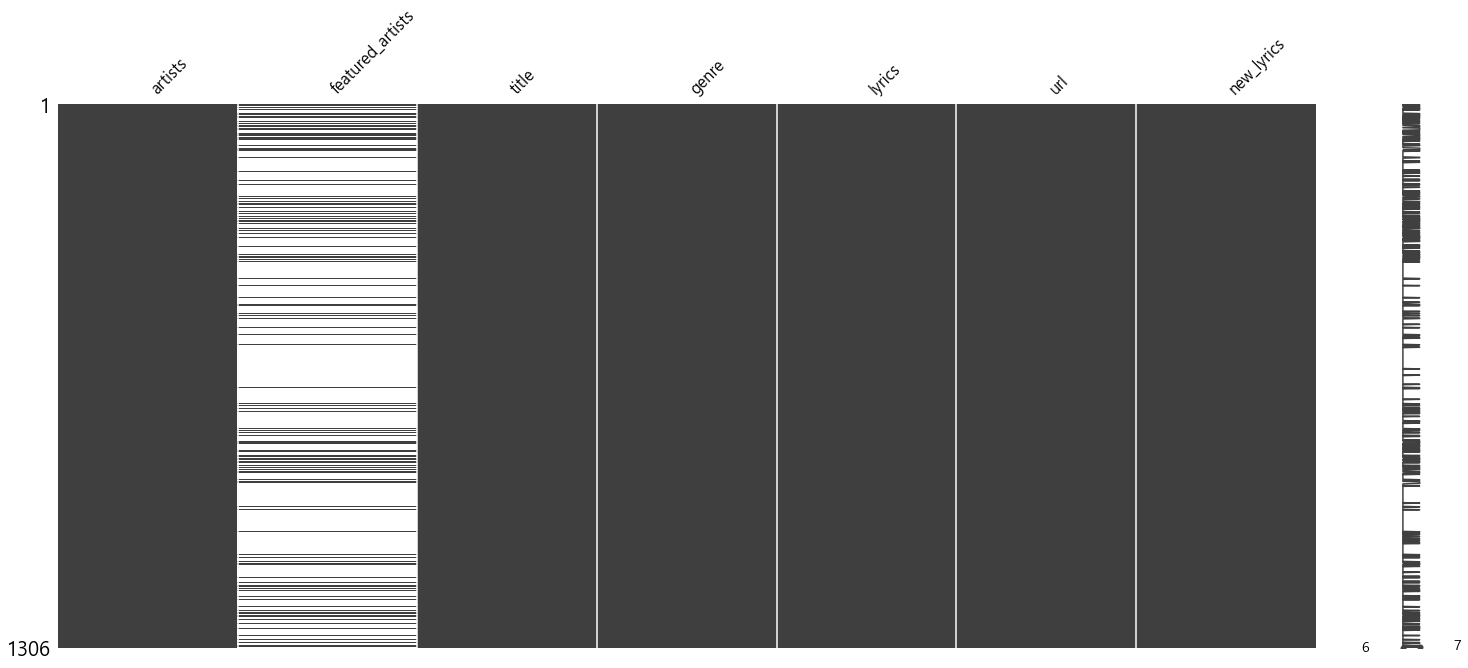

In [15]:
msno.matrix(data)
plt.show()

- 피처링 가수가 없는 가수가 많으며 피처링은 중요 요소가 아니기 때문에 결측치 그대로 진행

#### 2) 장르 확인

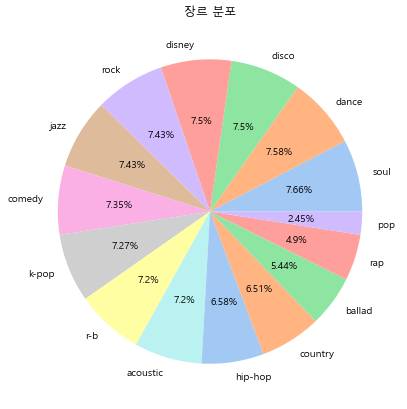

In [48]:
genre_cnt = data["genre"].value_counts()

plt.figure(figsize = (7, 7))

colors = sns.color_palette('pastel', len(genre_cnt))
plt.pie(genre_cnt.values, labels=genre_cnt.index, autopct="%1.3g%%", colors = colors)

plt.title("장르 분포")
plt.show()

- 데이터 수집 시, 장르를 균일하게 수집하였기 때문에 대부분 6~7.5%의 비율을 보인다.

#### 3) 가수 별 곡 수 확인

In [15]:
# 가수 별 데이터 수 카운팅
from collections import Counter

artists_cnt = [artist.strip() for artist in ','.join(list(data['artists'])).split(",")]
artists_freq = Counter(artists_cnt)

# top10
artists_freq = pd.DataFrame(artists_freq.most_common(10), columns = ['artists', 'size'])
artists_freq.head()

,artists,size
0,BTS,57
1,Taylor Swift,41
2,Eminem,38
3,Kanye West,30
4,Kendrick Lamar,27


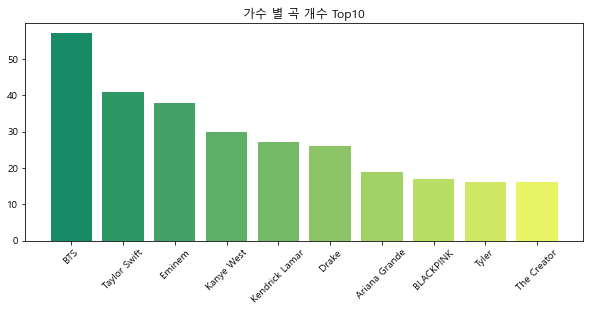

In [16]:
fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(artists_freq['artists'].iloc[:10]))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels(artists_freq['artists'].iloc[:10], rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('summer', len(artists_freq['artists'].iloc[:10])) # 바 차트 색상
ax1.bar(xtick_label_position, artists_freq['size'].iloc[:10], color=colors) # 바차트 출력

plt.title("가수 별 곡 개수 Top10")
plt.show()

- 가수 별 곡 개수를 살펴보았을 때, BTS의 곡이 가장 많았으며 테일러 스위프트, 에미넴 곡이 다음으로 많았다.

### 2. 가사 확인

In [17]:
from wordcloud import WordCloud
from konlpy.tag import *
import nltk
from konlpy.tag import Okt
from PIL import Image
import re

font_path = "data/D2Coding.ttf"
music_mask = np.array(Image.open("data/music_logo.png"))

#### 한국 가사, 영어 가사 분리

In [17]:
# 한국어와 영어 분리하여 토큰화
def tokenize_kr(sentence, tag = 'Noun', return_pos = False):
    okt = Okt()
    if return_pos: # 모든 형태소 분리
        return okt.pos(sentence)  
    
    return [word for word, tg in okt.pos(sentence) if tg == tag] # 특정 형태소 분리

def tokenize_en(sentence, tag = ['NN'], return_pos = False):
    tokenized = nltk.word_tokenize(sentence)
    if return_pos: # 모든 형태소 분리
        return nltk.pos_tag(tokenized)
    
    # 특정 형태소(명사, 형용사, 동사) 분리
    if tag == ['NN']:
        tag = ['NN', 'NNS', 'NNP', 'NNPS']
    elif tag == ['JJ']:
        tag = ['JJ', "JJR", "JJS"]
    elif tag == ['VB']:
        tag = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    return [word for word, tg in nltk.pos_tag(tokenized) if tg in tag]
    

In [18]:
# 한국어가 있다면 한국어 토크나이저 사용을 위해 한글 카운팅
# 한국어와 영어가 섞인 경우, 한글 수가 적은거는 영어로 토큰화
_compile = re.compile("[가-힣]+")
data['lang'] = data['new_lyrics'].apply(lambda x: 'kr' if len(_compile.findall(x)) >= 50 else 'en')

In [19]:
# 한글 가사, 영어 가사 데이터 분리
kr_df = data.loc[data['lang'] == 'kr']
en_df = data.loc[data['lang'] == 'en']

In [23]:
data['pos'] = None
data['noun'] = None
data['adj'] = None

# pos, noun, adj 나눠 토큰화
for idx, row in kr_df.iterrows(): # 한글 토크나이저
    data.at[idx, 'pos'] = tokenize_kr(row['new_lyrics'], return_pos = True)
    data.at[idx, 'noun'] = tokenize_kr(row['new_lyrics'], tag = 'Noun')
    data.at[idx, 'adj'] = tokenize_kr(row['new_lyrics'], tag = 'Adjective')

for idx, row in en_df.iterrows(): # 영어 토크나이저
    data.at[idx, 'pos'] = tokenize_en(row['new_lyrics'], return_pos = True)
    data.at[idx, 'noun'] = tokenize_en(row['new_lyrics'], tag = ['NN'])
    data.at[idx, 'adj'] = tokenize_en(row['new_lyrics'], tag = ['JJ'])

In [19]:
# 불용어 지정
from nltk.corpus import stopwords 

file = open("data/kor_stopwords.txt", 'r', encoding = "UTF-8")
kr_stopwords = file.read()
kr_stopwords = kr_stopwords.split()

stop_words = stopwords.words('english') + kr_stopwords

##### 1) 명사

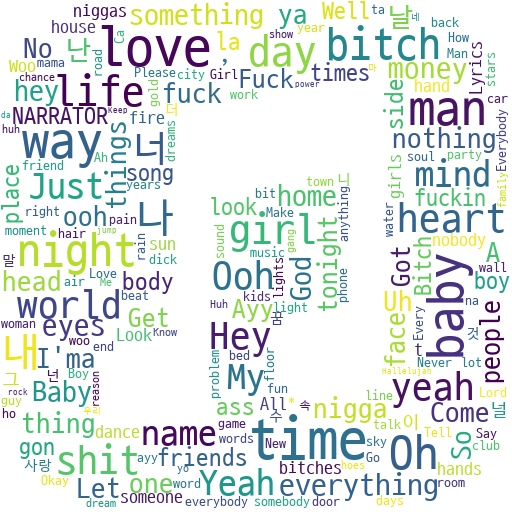

In [173]:
# 전체 데이터 셋 중 명사 클라우드
all_nouns = []
for row in data['noun']:
    all_nouns.extend(row)
    
counter = Counter(all_nouns)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, stopwords=stop_words, mask=music_mask)
wc.generate_from_frequencies(counter)
wc.to_image()

- 외국곡의 수가 많다보니 한글보다 영어의 단어가 많음을 볼 수 있다.
- 영어 가사는 시간, 사랑, 남자, 여자, 밤, 낮과 같은 단어가 많이 사용되고 있다.

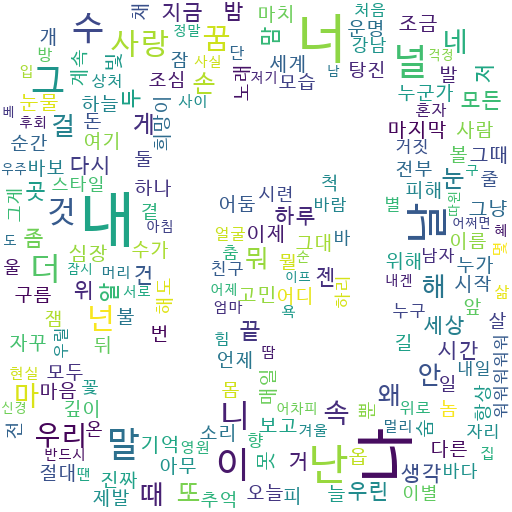

In [208]:
# 한글 데이터 셋 중 명사 클라우드
kr_nouns = []
for row in data.loc[data['lang'] == 'kr', 'noun']:
    kr_nouns.extend(row)
    
kr_counter = Counter(kr_nouns)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, stopwords=stop_words, mask=music_mask)
wc.generate_from_frequencies(kr_counter)
wc.to_image()

- 한글 가사도 너와 나, 사랑, 꿈과 같은 연애와 연관된 가사가 많이 사용되고 있다.

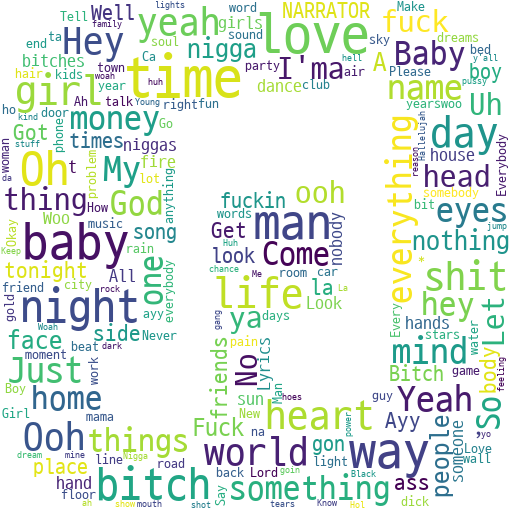

In [179]:
# 영어 데이터 셋 중 명사 클라우드
en_nouns = []
for row in data.loc[data['lang'] == 'en', 'noun']:
    en_nouns.extend(row)
    
counter = Counter(en_nouns)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, stopwords=stop_words, mask=music_mask)
wc.generate_from_frequencies(counter)
wc.to_image()

- 영어&명사 워드 클라우드는 전체 데이터셋의 형태와 유사하고 해석 또한 똑같다.

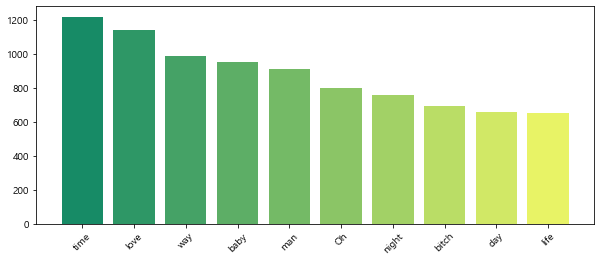

In [191]:
# 가장 많이 사용된 단어 top 10 확인
fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(counter.most_common(10)))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels([k for k, _ in counter.most_common(10)], rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('summer', len(counter.most_common(10))) # 바 차트 색상
ax1.bar(xtick_label_position,[v for _, v in counter.most_common(10)], color=colors) # 바차트 출력

plt.title("명사 빈도수 Top10")
plt.show()

- time과 love의 단어 빈도수가 가장 높으며 한국곡, 외국곡 모두 연애와 관련된 가사가 많다고 파악된다.

#### 2) 형용사

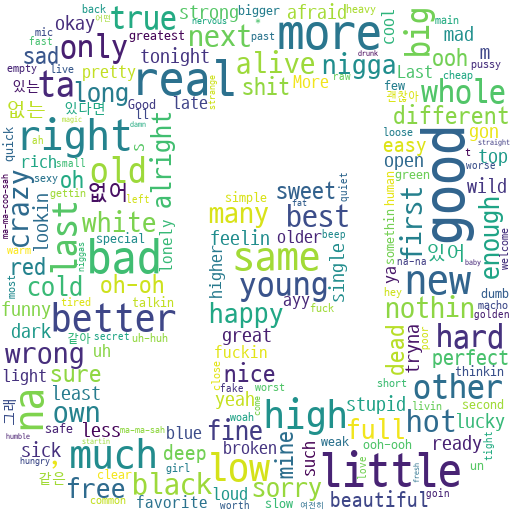

In [174]:
# 전체 데이터 셋 중 형용사 클라우드
all_adj = []
for row in data['adj']:
    all_adj.extend(row)
    
counter = Counter(all_adj)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, stopwords=stop_words, mask=music_mask)
wc.generate_from_frequencies(counter)
wc.to_image()

- good, real, little, better, more과 같은 형용사가 많이 사용되고 있다.

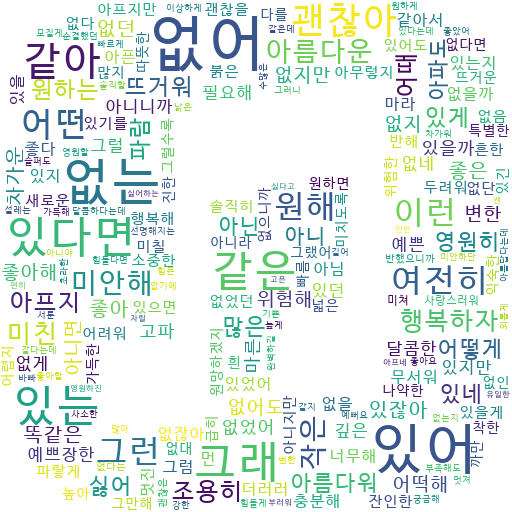

In [175]:
# 한글 데이터 셋 중 형용사 클라우드
kr_adj = []
for row in data.loc[data['lang'] == 'kr', 'adj']:
    kr_adj.extend(row)
    
counter = Counter(kr_adj)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, stopwords=stop_words, mask=music_mask)
wc.generate_from_frequencies(counter)
wc.to_image()

- 없어, 없는, 있다면과 같은 형용사로 보아 이별 노래가 많을 것으로 보인다.

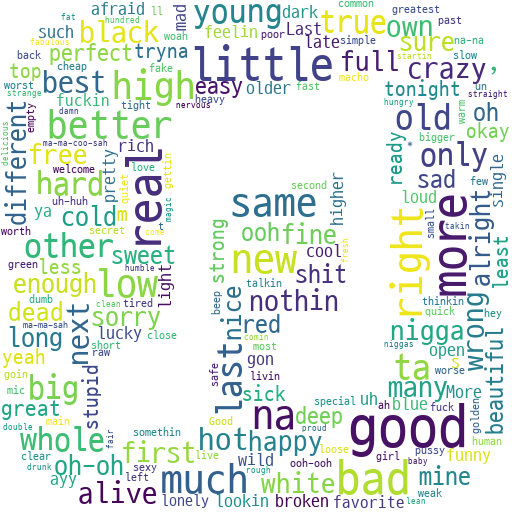

In [177]:
# 영어 데이터 셋 중 형용사 클라우드
en_adj = []
for row in data.loc[data['lang'] == 'en', 'adj']:
    en_adj.extend(row)
    
counter = Counter(en_adj)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, stopwords=stop_words, mask=music_mask)
wc.generate_from_frequencies(counter)
wc.to_image()

#### 한국 가사, 장르별로 나눠서 top10 확인

In [194]:
genres = data['genre'].unique()

In [243]:
kr_genre_nouns = {}

# 한국곡 장르별 명사 키워드 추출
for genre in genres:
    kr_genre_nouns[genre] = []
    for row in data[data['genre'] == genre].loc[data['lang'] == 'kr', 'noun']:
        kr_genre_nouns[genre].extend(row)

In [244]:
kr_genre_nouns = {k:v for k, v in kr_genre_nouns.items() if v != []}

In [245]:
for k, v in kr_genre_nouns.items():
    # 불용어 제거
    for word in v:
        if word in kr_stopwords:
            v.remove(word)
    kr_genre_nouns[k] = Counter(v)

In [315]:
file = open("kor_stopwords.txt", 'r', encoding='UTF-8')
kr_stopwords = file.read()
kr_stopwords = kr_stopwords.split()

In [320]:
import copy

# 불용어 제거
kr_counter = dict(kr_counter)
top_10 = copy.deepcopy(kr_counter)

for k, v in kr_counter.items():
    if k in kr_stopwords:
        del top_10[k]

In [321]:
top_10 = [w for w, c in Counter(top_10).most_common(10)]
top_10

['사랑', '꿈', '손', '눈', '끝', '맘', '모든', '세상', '우린', '밤']

In [324]:
kr_genre_n_cnt = {}
for key in kr_genre_nouns.keys():
    kr_genre_n_cnt[key] = []
    for keyword in top_10:
        kr_genre_n_cnt[key].append(kr_genre_nouns[key][keyword])
    
kr_genre_n_cnt

{'r-b': [3, 2, 2, 6, 3, 5, 1, 6, 1, 6],
 'rock': [6, 4, 11, 4, 8, 1, 2, 2, 0, 8],
 'hip-hop': [6, 11, 1, 4, 3, 1, 2, 4, 7, 2],
 'ballad': [27, 0, 2, 9, 2, 7, 3, 3, 0, 2],
 'k-pop': [77, 97, 55, 44, 44, 43, 45, 40, 39, 32],
 'dance': [7, 1, 1, 4, 2, 1, 5, 3, 7, 3]}

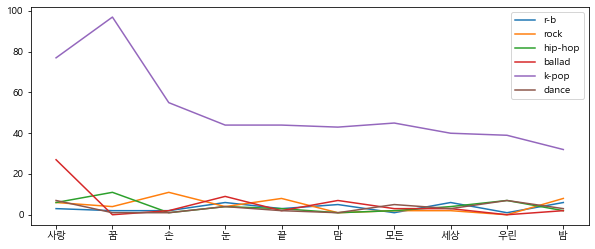

In [327]:
plt.figure(figsize=(10, 4))
for k, val in kr_genre_n_cnt.items():
    plt.plot(top_10, val, label = k)
plt.legend()
plt.show()

In [329]:
kr_df.groupby("genre").size()

genre
ballad     11
dance       4
hip-hop    13
k-pop      75
r-b        11
rock       10
dtype: int64

- k-pop 장르가 많아서 타 장르에 비하여 단어의 빈도수가 높으며 k-pop은 사랑, 꿈과 같은 희망사항 내용이 많은 것으로 보인다.
- 발라드의 경우, "사랑" 빈도수가 월등하게 높으며 힙합은 꿈 내용이 많은 것으로 보인다.

- 파악 내용
    - 지니어스 음악 사이트: 외국곡 >>>>> 한국곡
    - 외국 노래랑 한국 노래 따로 모델링할 것인지, 외국 노래 번역해서 KoBert로 통일할 것인지 결정 필요

- 결정 결과
    - 외국 노래: Bert 모델
    - 한국 노래: KoBert 모델

### 3. 토픽 모델링

#### 영어 가사

In [5]:
from gensim import corpora 
from gensim import models

In [53]:
stop_words+=['bitch', 'baby', 'oh', 'year', 'Yeah','Oh','shit', 'lt', 'gt']

In [54]:
documents=list(data.loc[data['lang'] == 'en', 'noun'])

texts = [[word for word in document if word not in stop_words]
        for document in documents]

dictionary = corpora.Dictionary(texts)                    # 사전 생성 (토큰화)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]     # 말뭉치 생성 (벡터화)

Dictionary(17841 unique tokens: ["'Cause", "'em", 'AK-47', 'Ac', 'Aftermath']...)


In [55]:
# LDA 모델링
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
        num_topics=2, random_state = 1)

# 주제마다 출현 확률이 높은 단어 순으로 출력
for t in lda.show_topics():
    print(t)

(0, '0.011*"love" + 0.009*"man" + 0.008*"time" + 0.008*"way" + 0.006*"night" + 0.006*"yeah" + 0.005*"Hey" + 0.004*"heart" + 0.004*"mind" + 0.004*"girl"')
(1, '0.009*"time" + 0.006*"way" + 0.005*"life" + 0.005*"love" + 0.005*"day" + 0.005*"night" + 0.005*"world" + 0.004*"girl" + 0.004*"name" + 0.004*"Ooh"')


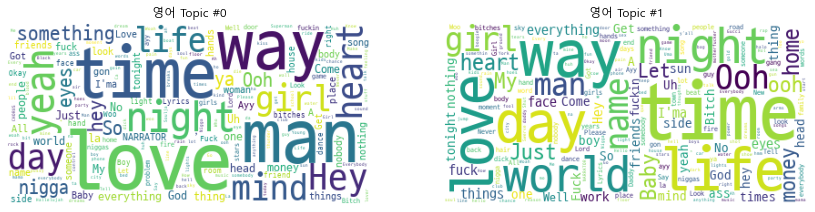

In [56]:
wc = WordCloud(background_color='white', font_path=font_path)            

plt.figure(figsize=(30,30))
for t in range(lda.num_topics):
    plt.subplot(5,4,t+1)
    x = dict(lda.show_topic(t,200))
    im = wc.generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("영어 Topic #" + str(t))

- 영어가사 대부분의 주제는 삶과 사랑과 같은 주제로 파악된다.

#### 한국 가사

In [32]:
documents=list(data.loc[data['lang'] == 'kr', 'noun'])

texts = [[word for word in document if word not in stop_words]
        for document in documents]

dictionary = corpora.Dictionary(texts)                    # 사전 생성 (토큰화)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]     # 말뭉치 생성 (벡터화)

Dictionary(1932 unique tokens: ['가죽', '강남대로', '개뿔', '걸음', '검']...)


In [35]:
# LDA 모델링
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
        num_topics=2, random_state = 1)

# 주제마다 출현 확률이 높은 단어 순으로 출력
for t in lda.show_topics():
	print(t)

(0, '0.018*"꿈" + 0.010*"손" + 0.008*"우린" + 0.007*"시간" + 0.007*"고민" + 0.007*"끝" + 0.007*"눈" + 0.006*"탕진" + 0.006*"잼" + 0.006*"밤"')
(1, '0.023*"사랑" + 0.010*"맘" + 0.009*"눈" + 0.008*"모든" + 0.007*"세상" + 0.007*"하루" + 0.007*"마지막" + 0.007*"끝" + 0.007*"젠" + 0.007*"꿈"')


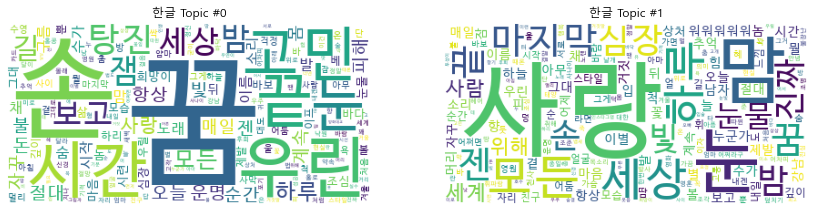

In [36]:
wc = WordCloud(background_color='white', font_path=font_path)            

plt.figure(figsize=(30,30))
for t in range(lda.num_topics):
    plt.subplot(5,4,t+1)
    x = dict(lda.show_topic(t,200))
    im = wc.generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("한글 Topic #" + str(t))

- 한글 가사는 수집 수가 적어 토픽을 2가지로 나눠봤을 때,
    - 1번째 토픽에서 **꿈, 고민, 시간, 세상**과 같은 키워드로 보아 미래, 꿈과 관련된 가사가 많을 것으로 파악된다.
    - 2번째 토픽에서 **심장, 모든, 마지막, 사랑**과 같은 키워드로 보아 절절한 사랑이야기가 많을 것으로 파악된다.

### 4. 네트워크 분석

In [ ]:
import networkx as nx

#### 영어 가사

In [67]:
documents =list(data.loc[data['lang'] == 'en', 'noun'])

story_sets = [[word for word in document if word not in stop_words]
        for document in documents]

In [68]:
## 연관규칙
from apyori import apriori

result = list(apriori(story_sets, min_support = 0.05))
ass_df = pd.DataFrame(result)
ass_df['length'] = ass_df['items'].apply(lambda x:len(x))
ass_df = ass_df[(ass_df['length'] == 2)&(ass_df['support']>=0.05)].sort_values(by='support',ascending=False)
ass_df.head()

,items,support,ordered_statistics,length
246,"(way, time)",0.164975,"[((), (way, time), 0.1649746192893401, 1.0), (...",2
206,"(time, life)",0.126058,"[((), (time, life), 0.1260575296108291, 1.0), ...",2
176,"(day, time)",0.113367,"[((), (day, time), 0.11336717428087986, 1.0), ...",2
214,"(love, time)",0.112521,"[((), (love, time), 0.11252115059221658, 1.0),...",2
218,"(man, time)",0.111675,"[((), (man, time), 0.1116751269035533, 1.0), (...",2


In [69]:
# 네트워크 그래프 정의
G = nx.Graph()
ar = (ass_df['items']); G.add_edges_from(ar)

# 패이지랭크: 노드 순위, 색상, 크기 지정 유용
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize-min(nsize))/(max(nsize)-min(nsize))

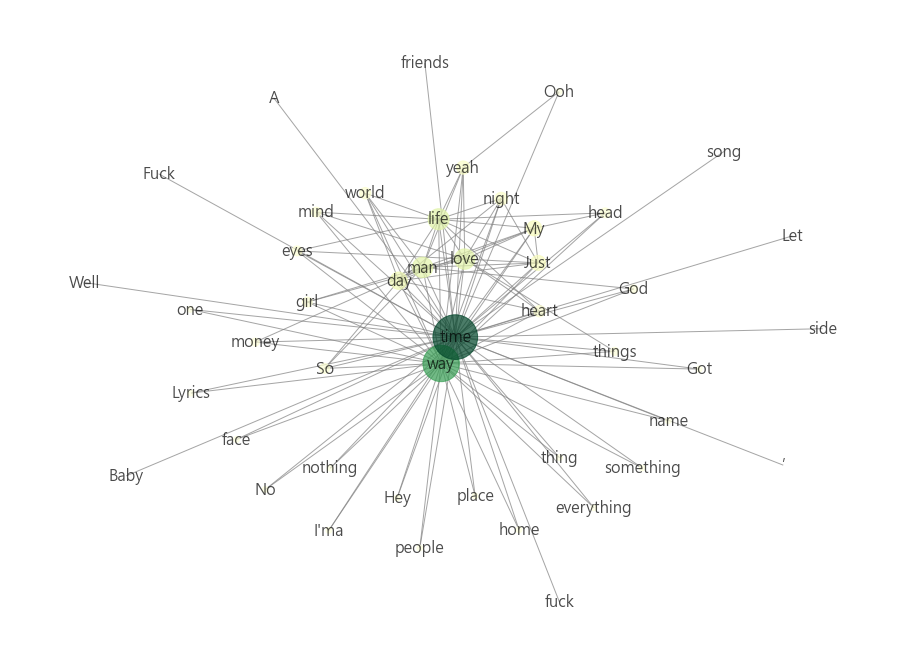

In [70]:
plt.figure(figsize = (16, 12))
plt.axis('off')
nx.draw_networkx(G, font_size = 16, font_family = font_name, node_color = list(pr.values()), 
                node_size = nsize, alpha = 0.7, edge_color = '.5', cmap = plt.cm.YlGn)
plt.show()

- 영어 가사에는 time, way 단어가 가장 많이 출현
- time과 way 간 연관성이 높아서 대부분 공통적으로 사용되는 것으로 보이며 남자, 사랑, 삶과 같은 소재와 많이 쓰일 것으로 추측된다.

#### 한글 가사

In [58]:
documents =list(data.loc[data['lang'] == 'kr', 'noun'])

story_sets = [[word for word in document if word not in stop_words]
        for document in documents]

In [63]:
## 연관규칙
result = list(apriori(story_sets, min_support = 0.05))
ass_df = pd.DataFrame(result)
ass_df['length'] = ass_df['items'].apply(lambda x:len(x))
ass_df = ass_df[(ass_df['length'] == 2)&(ass_df['support']>=0.05)].sort_values(by='support',ascending=False)
ass_df.head()

,items,support,ordered_statistics,length
190,"(시간, 눈)",0.145161,"[((), (시간, 눈), 0.14516129032258066, 1.0), ((눈)...",2
186,"(세상, 눈)",0.129032,"[((), (세상, 눈), 0.12903225806451613, 1.0), ((눈)...",2
185,"(사랑, 눈)",0.120968,"[((), (사랑, 눈), 0.12096774193548387, 1.0), ((눈)...",2
217,"(모든, 사랑)",0.112903,"[((), (모든, 사랑), 0.11290322580645161, 1.0), ((모...",2
162,"(끝, 눈)",0.096774,"[((), (끝, 눈), 0.0967741935483871, 1.0), ((끝), ...",2


In [65]:
# 네트워크 그래프 정의
G = nx.Graph()
ar = (ass_df['items']); G.add_edges_from(ar)

# 패이지랭크: 노드 순위, 색상, 크기 지정 유용
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize-min(nsize))/(max(nsize)-min(nsize))

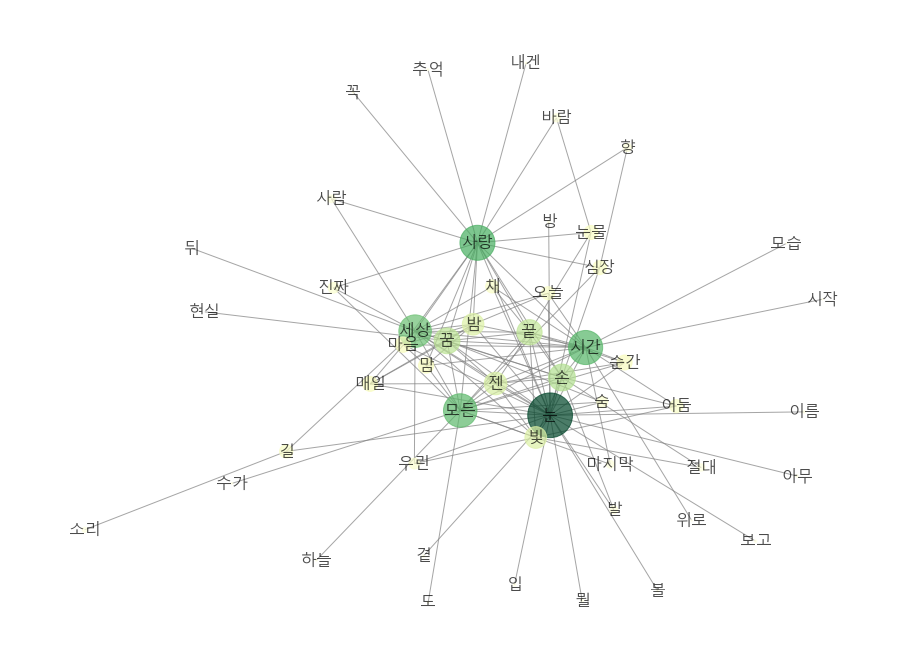

In [66]:
plt.figure(figsize = (16, 12))
plt.axis('off')
nx.draw_networkx(G, font_size = 16, font_family = font_name, node_color = list(pr.values()), 
                node_size = nsize, alpha = 0.7, edge_color = '.5', cmap = plt.cm.YlGn)
plt.show()

- 한글가사에는 눈, 시간, 사랑, 세상, 모든이라는 단어가 가장 많이 출현
- 눈은 빛과 연관성이 가장 높은 것으로 보아 내리는 눈이 아니고 눈빛이라는 형태로 많이 쓰인것으로 보인다.
- 시간은 끝, 순간, 어둠과 연관성이 높은 것으로 보아 이별과 관련된 노래가 많다고 추정된다.